## <b>Uplift Моделирования</b>

### <b><span style='color:#686dec'>Обзор базовых подходов</span></b>

- В практической части вебинара посмотрим на базовые подходы `Uplift` Моделирования

> - Задача `Uplift` моделирования помогает нам выявить **чистый эффект от коммуникации**, или выявить убеждаемых клиетнов 
> - `Uplift` Это разница между результатами группы, которая подверглась воздействию (например, увидела рекламу), и контрольной группой, которая не подвергалась воздействию. 


- Для простоты, будем использовать библиотеку `sklift`

Важно отметить 

- `КГ` (Контрольная группа) коммуникации нет и `ЦГ` (Целевая группа) коммуникация есть

In [2]:
# import sys
# !{sys.executable} -m pip install scikit-uplift==0.5.1 catboost pandas==1.3.5

### <b><span style='color:#686dec'>Импортируем библиотеки</span></b>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklift.datasets import fetch_x5
from sklift.metrics import uplift_at_k
import pandas as pd
import numpy as np

random_state = 47
k = 0.1

### <b><span style='color:#686dec'>Читаем данные</span></b>

Данные у нас будут от X5, используем только часть данных, опираясть только на 5 фичей (для простоты)

In [8]:
df_clients = pd.read_csv('fetch_x5_clients.csv')
df_train = pd.read_csv('fetch_x5_train.csv')
df_clients = df_clients.dropna()
df_all = df_clients.merge(df_train,on='client_id')
df_clients = df_all[['client_id','first_issue_date','first_redeem_date','age','gender']]
df_train = df_all[['client_id','treatment_flg','target']]

In [3]:
df_clients.head(2)

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F


In [7]:
df_train.head(2)

,client_id,treatment_flg,target
0,000012768d,0,1
1,000036f903,1,1


In [9]:
print(f"Dataset features shape: {df_clients.shape}")
print(f"Dataset train shape: {df_train.shape}")
print(f"Dataset target mean: {df_train.target.mean()}")
print(f"Dataset treatment mean: {df_train.treatment_flg.mean()}")

Dataset features shape: (182493, 5)
Dataset train shape: (182493, 3)
Dataset target mean: 0.6444904736072069
Dataset treatment mean: 0.5016247198522683


In [10]:
df_clients = df_clients.set_index('client_id')
df_train = df_train.set_index('client_id')

### <b><span style='color:#686dec'>Предобработка</span></b>

Удостоверимся что категориальные фичи имеют формат `category`

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_clients['gender'] = encoder.fit_transform(df_clients['gender'])

Превращаем `datetime` в относительное время (в секундах) от 1970 года

In [12]:
# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = (pd.to_datetime(df_features['first_issue_date'])- pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = (pd.to_datetime(df_features['first_redeem_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

df_features.head(2)

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
000012768d,45,2,1501947648,1515094207,13146559
000036f903,72,0,1491832463,1492951076,1118613


Разбиваем выборки на две подвыборки

In [13]:
# отделяем 30% - пятую часть всего - на тестовую выборку
train, test = train_test_split(df_features, test_size=0.3, random_state=random_state)

indices_train = train.index.tolist()
indices_test = test.index.tolist()

X_train = df_features.loc[indices_train, :]
y_train = df_train.loc[indices_train, 'target']
treat_train = df_train.loc[indices_train, 'treatment_flg']

X_test = df_features.loc[indices_test, :]
y_test = df_train.loc[indices_test, 'target']
treat_test =  df_train.loc[indices_test, 'treatment_flg']

targets = [y_train, y_test]
treatmnets = [treat_train, treat_test]
names = ['train:',  'test:']

In [14]:
print('Баланс таргета на разбиениях:\n')
i = 0
for target in targets:
    pc = target.mean()
    print(names[i], pc)
    i += 1

print('\nБаланс воздействия на разбиениях:\n')
i = 0
for treatmnet in treatmnets:
    pc = treatmnet.mean()
    print(names[i], pc)
    i += 1

Баланс таргета на разбиениях:

train: 0.644831500254413
test: 0.6436947468400672

Баланс воздействия на разбиениях:

train: 0.5018983130455204
test: 0.500986337400453


Создалим словарь куда будем сохранять результаты метрики `uplift`

In [15]:
models_results = {
    'approach': [],
    f'train_uplift@{k*100}%': [],
    f'test_uplift@{k*100}%': []
}

### <b><span style='color:#686dec'>Подходы с Одной Модели</span></b>

#### (1) Трансформация Класса


In [17]:
from sklift.models import ClassTransformation
from sklearn.ensemble import GradientBoostingClassifier

In [18]:
ct = ClassTransformation(
    GradientBoostingClassifier()
    )

ct = ct.fit(X_train, y_train, treat_train)

uplift_ct_train = ct.predict(X_train)
uplift_ct = ct.predict(X_test)
print(uplift_ct[:5])

[ 0.03508148  0.03092437  0.04037575 -0.05105889  0.01682562]


2 стратегии (`strategy`) в `uplift_at_k`
- **by_group** (делаем сортировку по uplift внутри каждой персентильки)
- **overall** (делаем сортировку глобально)

In [19]:
ct_score_train = uplift_at_k(y_true=y_train, 
                             uplift=uplift_ct_train, 
                             treatment=treat_train, 
                             strategy='by_group', k=k)

ct_score = uplift_at_k(y_true=y_test, 
                       uplift=uplift_ct, 
                       treatment=treat_test, 
                       strategy='by_group', k=k)

models_results['approach'].append('ClassTransformation')
models_results[f'train_uplift@{k*100}%'].append(ct_score_train)
models_results[f'test_uplift@{k*100}%'].append(ct_score)

# явное переобучение
pd.DataFrame(models_results) 

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.201149,0.118589


Как и другие метрики, мы можем сравнить метрику на train и test подвыборках, сдесь у нас явное переобучение

#### (2) Одна модель с признаком коммуникации

Самое простое и интуитивное решение: 
- модель обучается одновременно на двух группах, при этом **бинарный флаг коммуникации** выступает в качестве дополнительного признака (k+1) фичу
- Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. 
- Вычитая вероятности по каждому наблюдению, получим искомы uplift.
- В `sklift` реализация в методе `SoloModel`

In [21]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

In [23]:
sm = SoloModel(
    GradientBoostingClassifier()
    )

# Обучаем модель
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm_train = sm.predict(X_train)
uplift_sm = sm.predict(X_test)
print(uplift_sm[:5])

[ 0.01861624  0.03623787  0.02475317 -0.01291694  0.02082576]


In [24]:
sm_score_train = uplift_at_k(y_true=y_train, uplift=uplift_sm_train, treatment=treat_train, strategy='by_group', k=k)
sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=k)

models_results['approach'].append('SoloModel')
models_results[f'train_uplift@{k*100}%'].append(sm_score_train)
models_results[f'test_uplift@{k*100}%'].append(sm_score)

pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.201149,0.118589
1,SoloModel,0.088193,0.083730


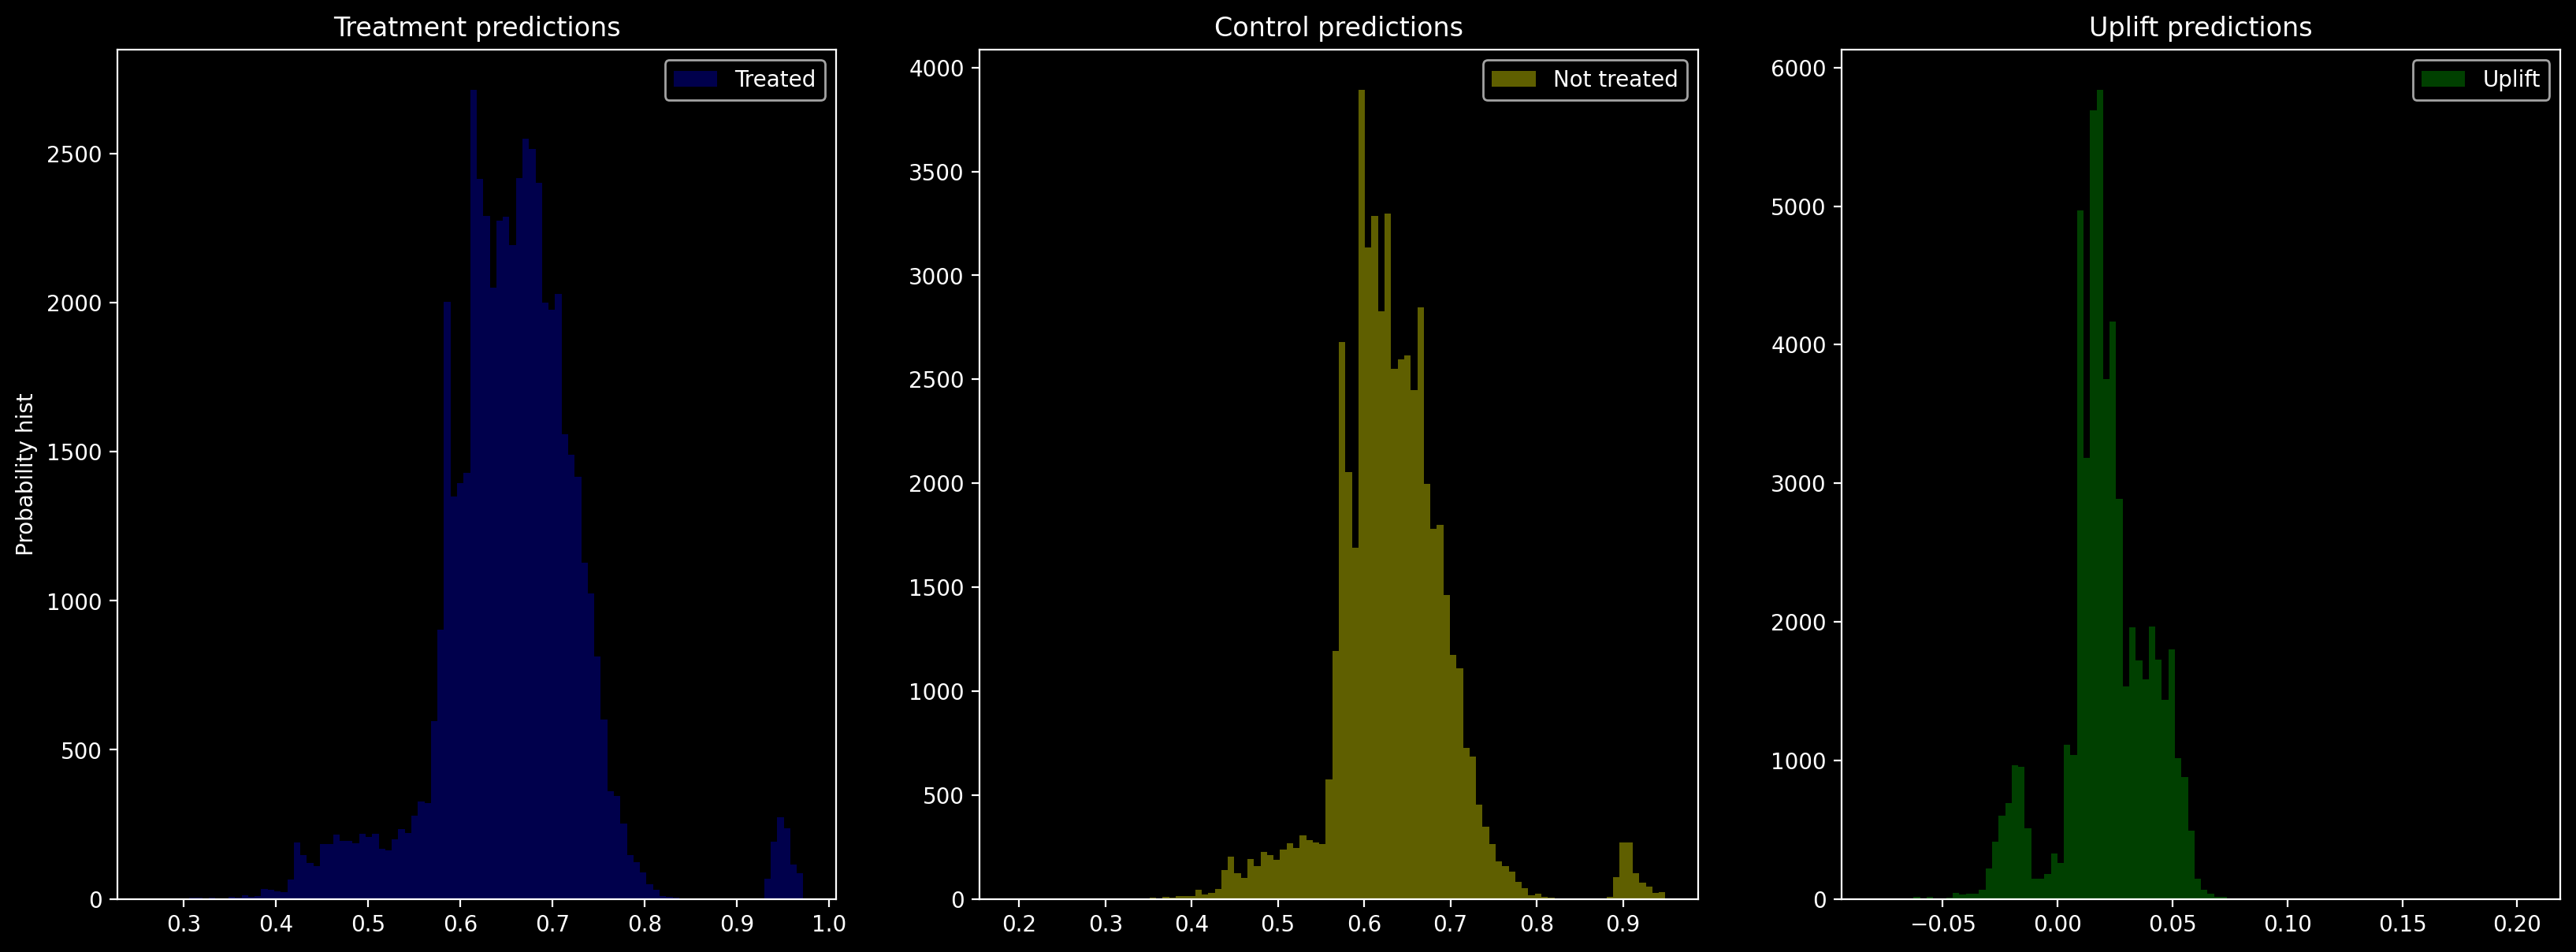

In [25]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

### <b><span style='color:#686dec'>Подходы с двумя моделями</span></b>

#### (1) Две независимые модели (t-Learner)

- Реализация `sklift` в `TwoModels` + **vanilla**
- Обучить модель на данных целевой группы (t) (modelt)
- Обучить Вторую модель на данных контрольной группы (c) (modelc)
- Чтобы получить **uplift** для тестовых клиентов:

    - (а) проскорить их первой моделью 
    - (б) проскорить их второй моделью 
    - Найти разницу двух векторов

In [27]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt = GradientBoostingClassifier(),
    estimator_ctrl = GradientBoostingClassifier(),
    method='vanilla'
)

tm = tm.fit(X_train, y_train, treat_train)

uplift_tm_train = tm.predict(X_train)
uplift_tm = tm.predict(X_test)
print(uplift_tm[:5])

[ 0.03633365  0.03156543  0.03352265 -0.05856611  0.02573542]


In [28]:
tm_score_train = uplift_at_k(y_true=y_train, uplift=uplift_tm_train, treatment=treat_train, strategy='by_group', k=k)
tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=k)

models_results['approach'].append('TwoModels')
models_results[f'train_uplift@{k*100}%'].append(tm_score_train)
models_results[f'test_uplift@{k*100}%'].append(tm_score)

pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.201149,0.118589
1,SoloModel,0.088193,0.083730
2,TwoModels,0.159321,0.070591


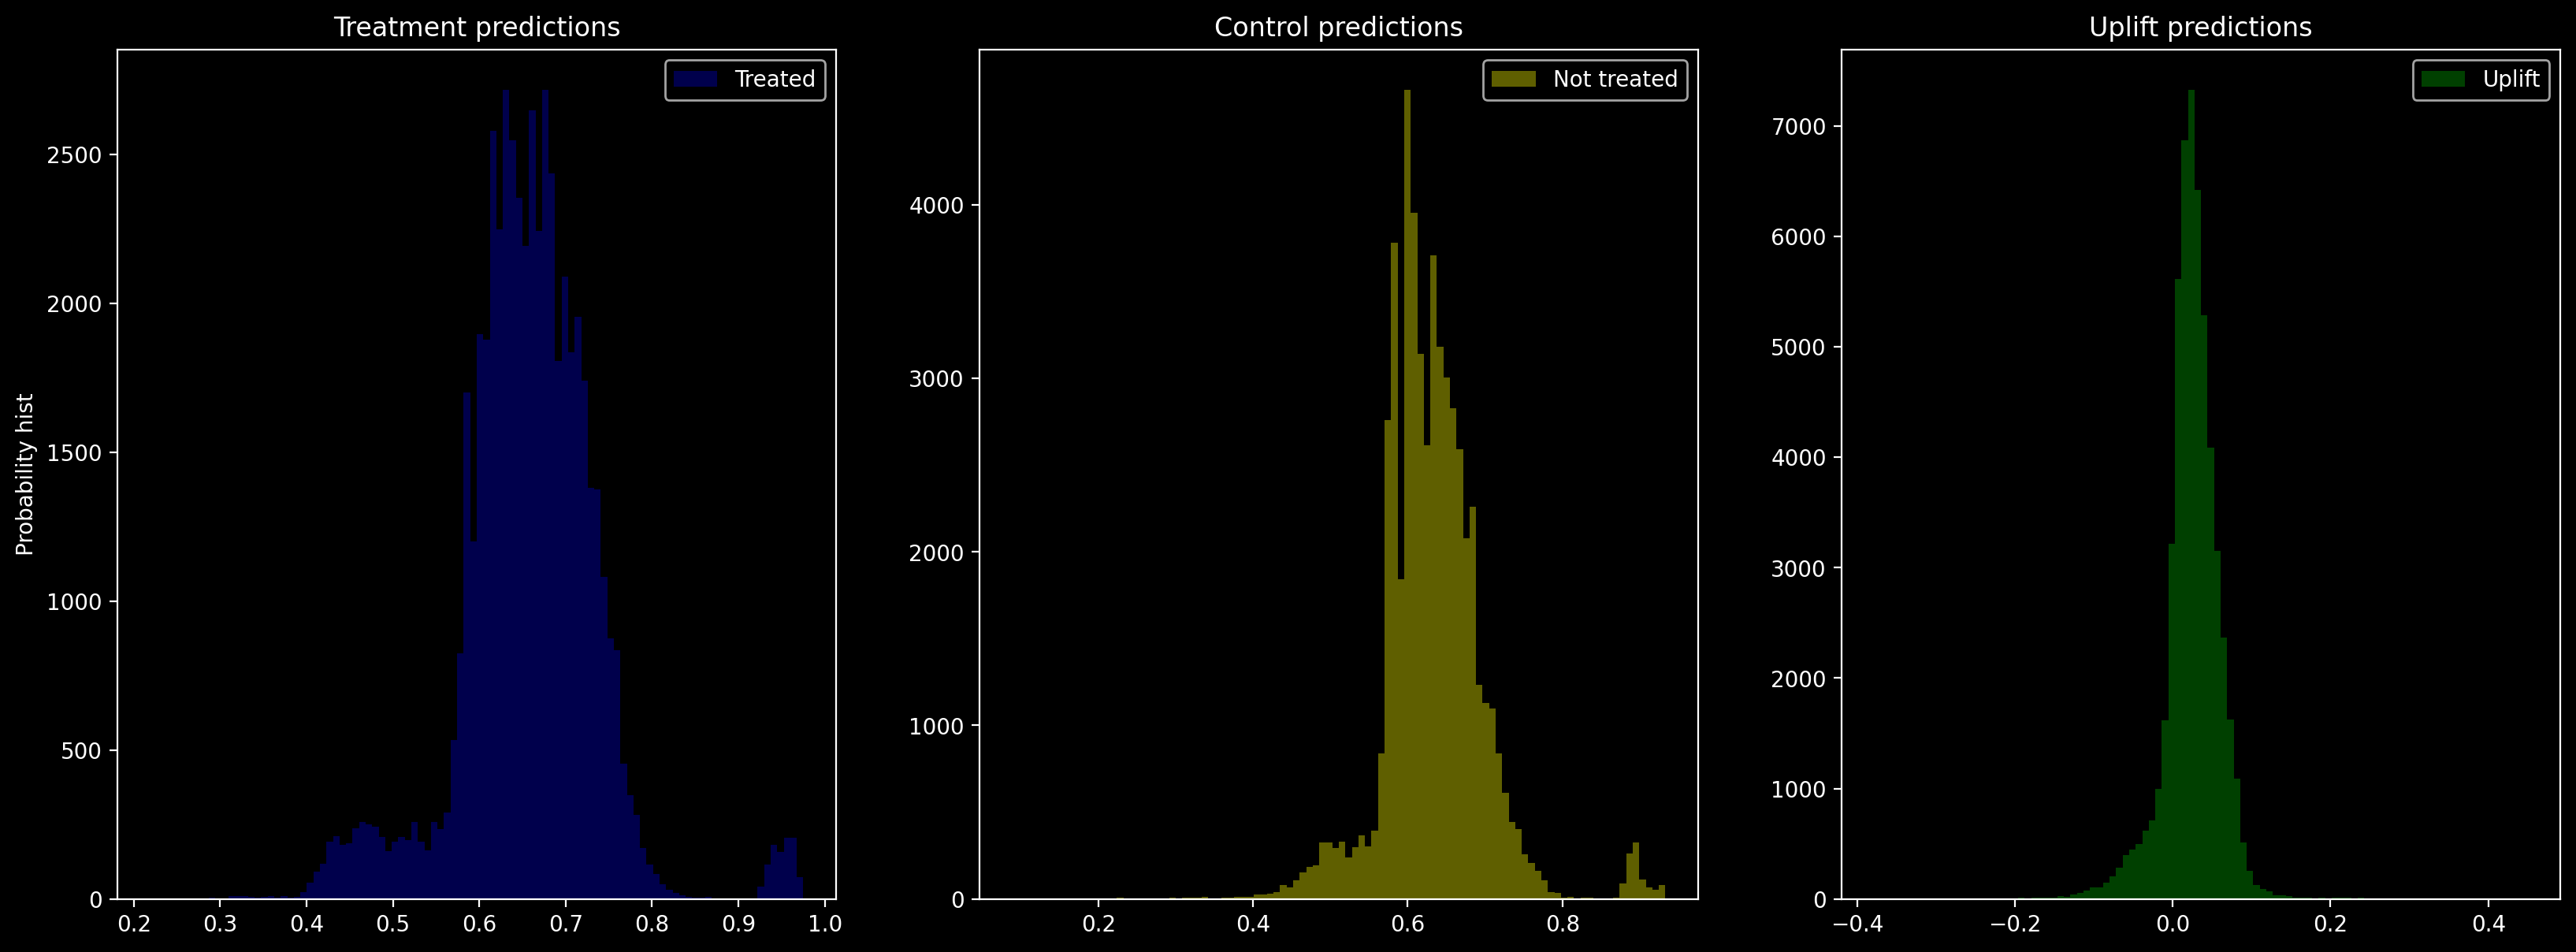

In [29]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
tm_trmnt_preds = tm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
tm_ctrl_preds = tm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=tm_trmnt_preds, ctrl_preds=tm_ctrl_preds);

#### (2) Две зависимые модели

- Реализация `sklift` в `TwoModels` + **ddr_control**
- Обучаем модель на данных контрольной группы (c) (modelc)
- С помощью этой модели получить предикт на клиетнах целевой группы (modelc).pred_proba(t)
- Обучаем вторую модель на (признаках целевой группы (t) + предикт с прошлого шага как доп. фича) (modelt)*
- Чтобы получить **uplift** для тестовых клиентах

    - (а) Проскорьте клиентов первой моделью 
    - (б) Добавьте полученные предикты как фичу и проскорьте второй моделью
    - Найдите разность пунктов (а) и (б)

*Можно и обратным образом 

In [35]:
tm_ctrl = TwoModels(
    estimator_trmnt=GradientBoostingClassifier(),
    estimator_ctrl=GradientBoostingClassifier(),
    method='ddr_control'
)

tm_ctrl = tm_ctrl.fit(X_train, y_train, treat_train)

uplift_tm_ctrl_train = tm_ctrl.predict(X_train)
uplift_tm_ctrl = tm_ctrl.predict(X_test)
print(uplift_tm_ctrl[:5])

[ 0.03621028  0.03075091  0.03341193 -0.04307654  0.0292164 ]


In [36]:
tm_ctrl_score_train = uplift_at_k(y_true=y_train, 
                                  uplift=uplift_tm_ctrl_train, 
                                  treatment=treat_train, 
                                  strategy='by_group', k=k)

tm_ctrl_score = uplift_at_k(y_true=y_test, 
                            uplift=uplift_tm_ctrl, 
                            treatment=treat_test, 
                            strategy='by_group', k=k)

models_results['approach'].append('TwoModels_ddr_control')
models_results[f'train_uplift@{k*100}%'].append(tm_ctrl_score_train)
models_results[f'test_uplift@{k*100}%'].append(tm_ctrl_score)


pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.201149,0.118589
1,SoloModel,0.088193,0.083730
2,TwoModels,0.159321,0.070591
3,TwoModels_ddr_control,0.172037,0.123702


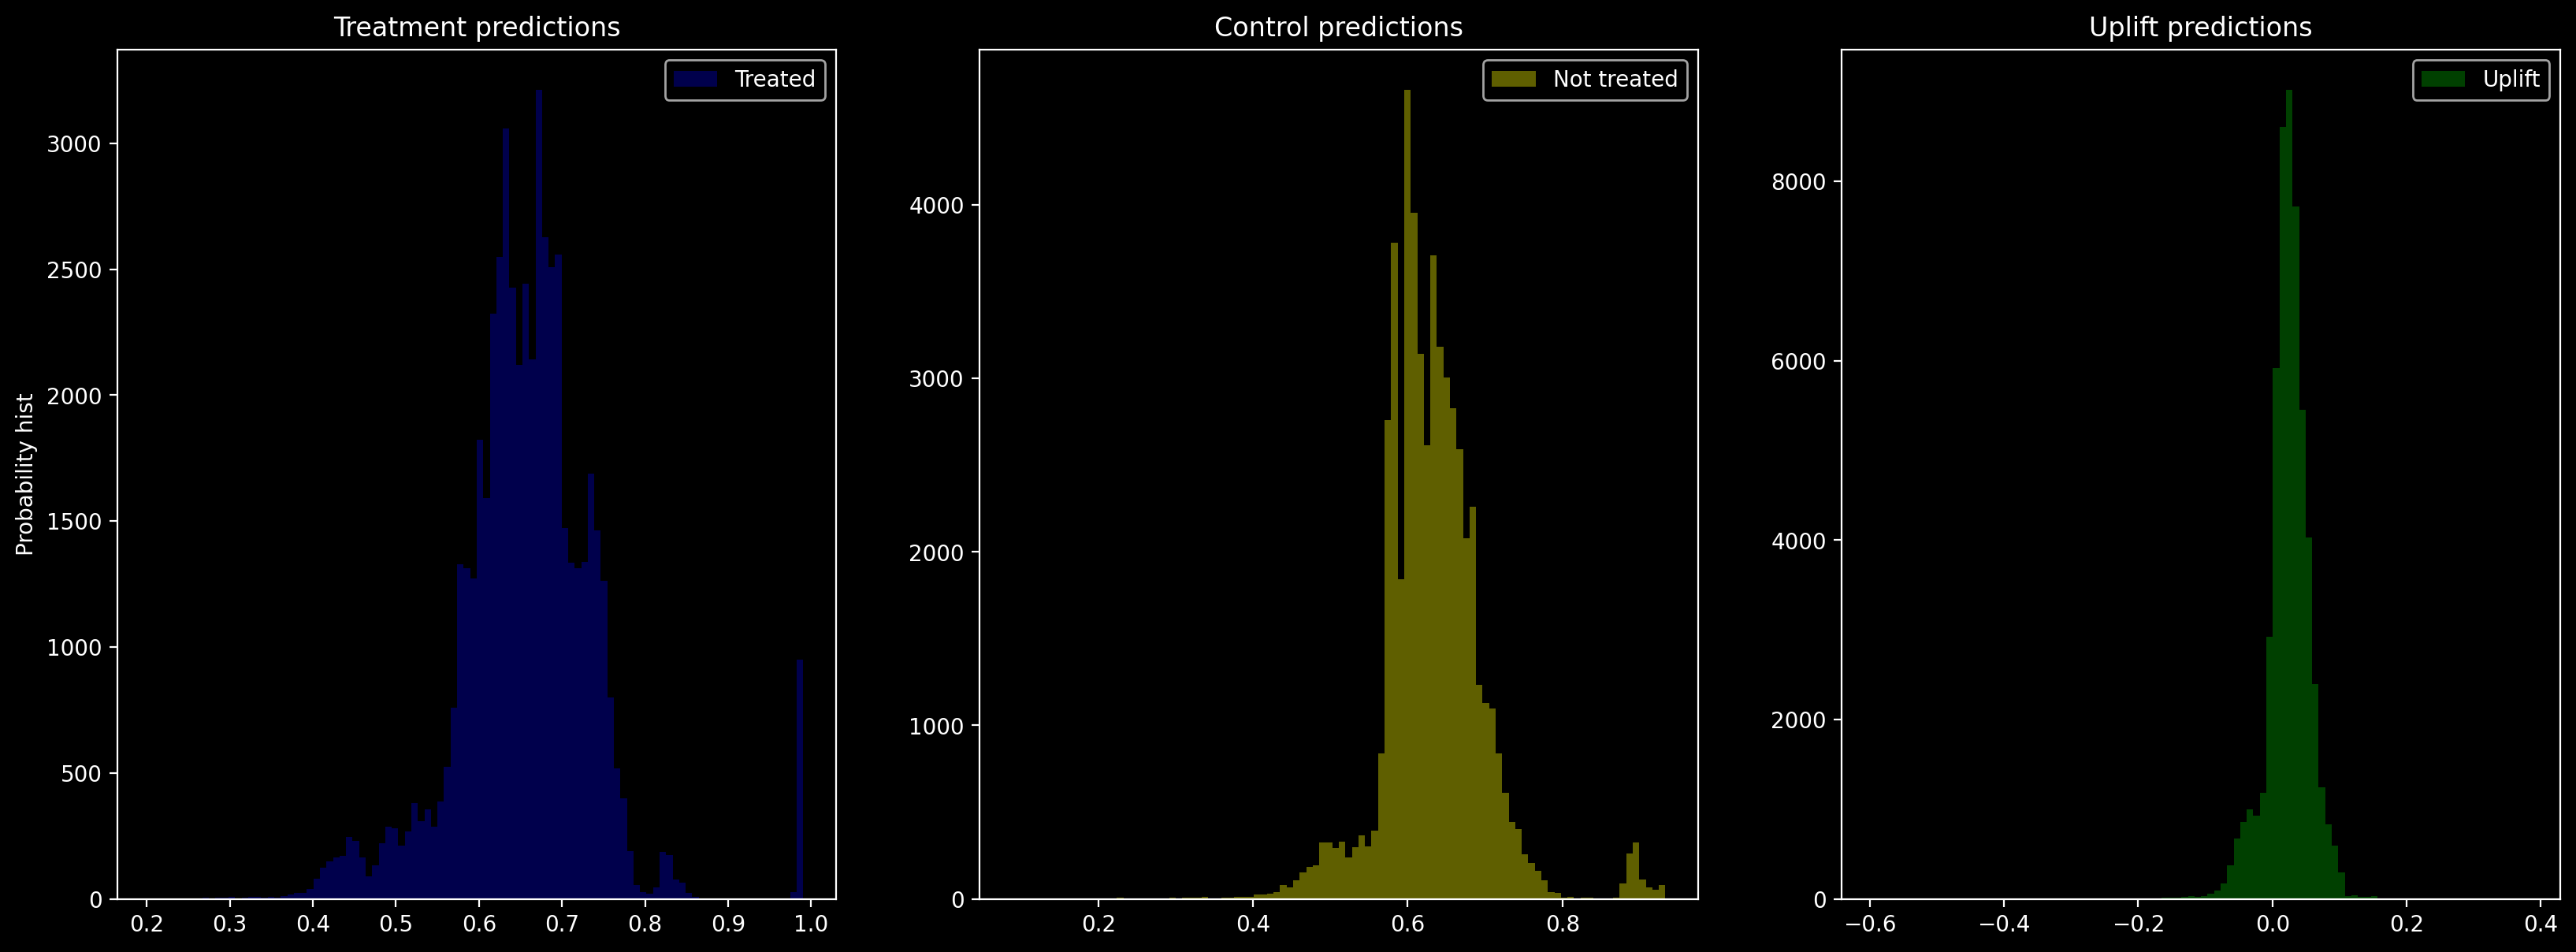

In [37]:
plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);



*Аналогичным образом можно сначала обучить классификатор $P^T$, а затем использовать его предсказания в качестве признака для классификатора $P^C$.

In [39]:
tm_trmnt = TwoModels(
    estimator_trmnt=GradientBoostingClassifier(),
    estimator_ctrl=GradientBoostingClassifier(),
    method='ddr_treatment'
)

tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train
)

uplift_tm_trmnt_train = tm_trmnt.predict(X_train)
uplift_tm_trmnt = tm_trmnt.predict(X_test)
print(uplift_tm_trmnt[:5])

[ 0.03124574  0.01680991  0.03615345 -0.09655285  0.02634465]


In [40]:
tm_trmnt_score_train = uplift_at_k(y_true=y_train, uplift=uplift_tm_trmnt_train, treatment=treat_train, strategy='by_group', k=k)
tm_trmnt_score = uplift_at_k(y_true=y_test, uplift=uplift_tm_trmnt, treatment=treat_test, strategy='by_group', k=k)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results[f'train_uplift@{k*100}%'].append(tm_trmnt_score_train)
models_results[f'test_uplift@{k*100}%'].append(tm_trmnt_score)

pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.201149,0.118589
1,SoloModel,0.088193,0.083730
2,TwoModels,0.159321,0.070591
3,TwoModels_ddr_control,0.172037,0.123702
4,TwoModels_ddr_treatment,0.141788,0.051622


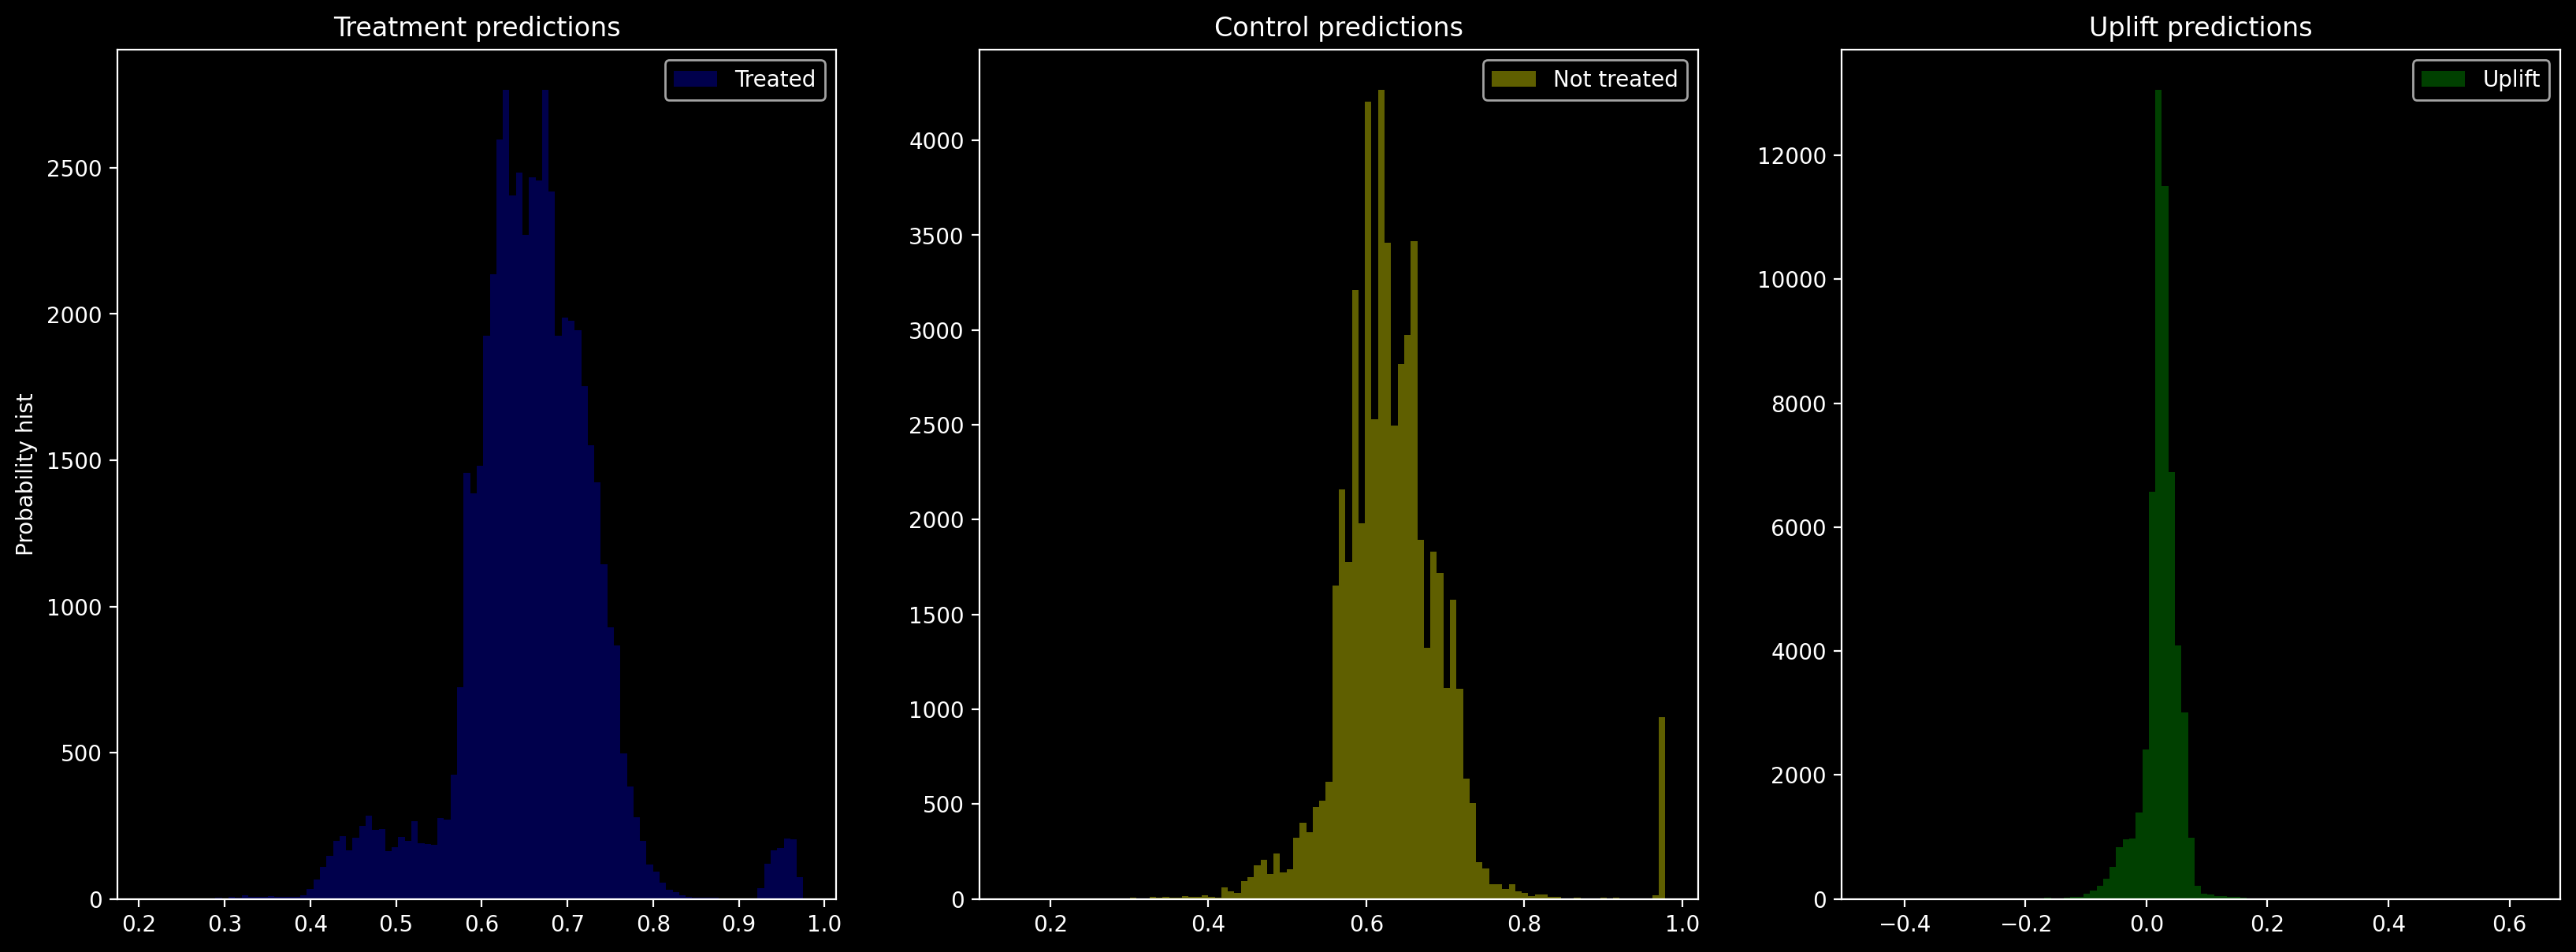

In [41]:
plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

### <b><span style='color:#686dec'>Сравним Метрики</span></b>

#### (1) uplift_at_k

- метрика `uplift_at_k` полезна для понимания реального воздействия на целевую аудиторию и для оптимизации стратегий взаимодействия с пользователями.

In [42]:
pd.DataFrame(data=models_results).sort_values(f'test_uplift@{k*100}%', ascending=False)

,approach,train_uplift@10.0%,test_uplift@10.0%
3,TwoModels_ddr_control,0.172037,0.123702
0,ClassTransformation,0.201149,0.118589
1,SoloModel,0.088193,0.083730
2,TwoModels,0.159321,0.070591
4,TwoModels_ddr_treatment,0.141788,0.051622


In [53]:
# Проверка структуры данных. Необходимо, чтобы запустился расчет метрик на особых версиях библиотек
print(f'y_test структура: {y_test.shape}, тип: {y_test.dtype}')
print(f'uplift_ct структура: {uplift_ct.shape}, тип: {uplift_ct.dtype}')
print(f'treat_test структура: {treat_test.shape}, тип: {treat_test.dtype}')

# Если обнаружены вложенные структуры, преобразовать их в одномерные массивы
if y_test.ndim > 1:
    y_test = y_test.flatten()

if uplift_ct.ndim > 1:
    uplift_ct = uplift_ct.flatten()

if treat_test.ndim > 1:
    treat_test = treat_test.flatten()

y_test структура: (54748,), тип: int64
uplift_ct структура: (54748,), тип: float64
treat_test структура: (54748,), тип: int64


#### (2) uplift_by_percentile

In [55]:
# from sklift.metrics import uplift_by_percentile
# import warnings; warnings.filterwarnings('ignore')

# # по бакетам данные о response_rate_treatment / response_rate_control
# uplift_by_percentile(y_test, uplift_ct, treat_test,
#                      strategy='overall',
#                      total=True, std=True, bins=10)

#### (3) weighted_average_uplift

По всей выборке, усредненная метрика `uplift`

In [56]:
from sklift.metrics import weighted_average_uplift

uplift_full_data_ct = weighted_average_uplift(y_test, uplift_ct, treat_test, bins=10)
uplift_full_data_sm = weighted_average_uplift(y_test, uplift_sm, treat_test, bins=10)
print(f"average uplift on test data CT: {uplift_full_data_ct:.4f}")
print(f"average uplift on test data SM: {uplift_full_data_sm:.4f}")

average uplift on test data CT: 0.0346
average uplift on test data SM: 0.0356


#### (5) plot_uplift_by_percentile

- График показываем какой `uplift` на конкретном percentile
- Дает возможность понять к кем коммуницировать 
    - Берем топ 30% и на них запускаем компанию 
- График должен быть монотонный 

In [62]:
# from sklift.viz import plot_uplift_by_percentile

# # line plot
# plot_uplift_by_percentile(y_test, uplift_ct, treat_test,
#                           strategy='overall', kind='line');

In [64]:
# # bar plot
# plot_uplift_by_percentile(y_test, uplift_ct, treat_test, strategy='overall', kind='bar');

#### (6) plot_uplift_curve, plot_qini_curve
- `Uplift Curve` показывает, как изменяется прирост (uplift) по мере увеличения доли целевой аудитории, на которую воздействует кампания. Она помогает оценить, насколько эффективно воздействие на определённую группу пользователей.
- `Qini Curve` является более продвинутой версией `Uplift Curve` и позволяет оценить эффективность модели с точки зрения её способности увеличивать доход или другие ключевые показатели.



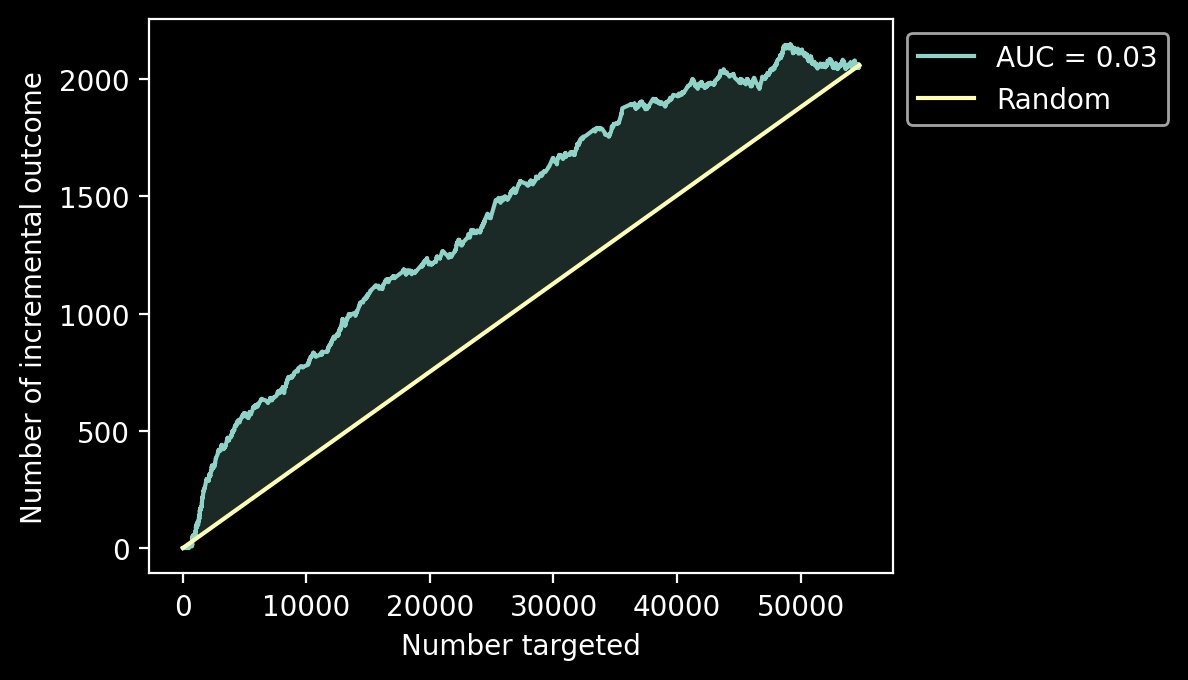

In [65]:
from sklift.viz import plot_uplift_curve

# with ideal curve
# perfect=True
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False);

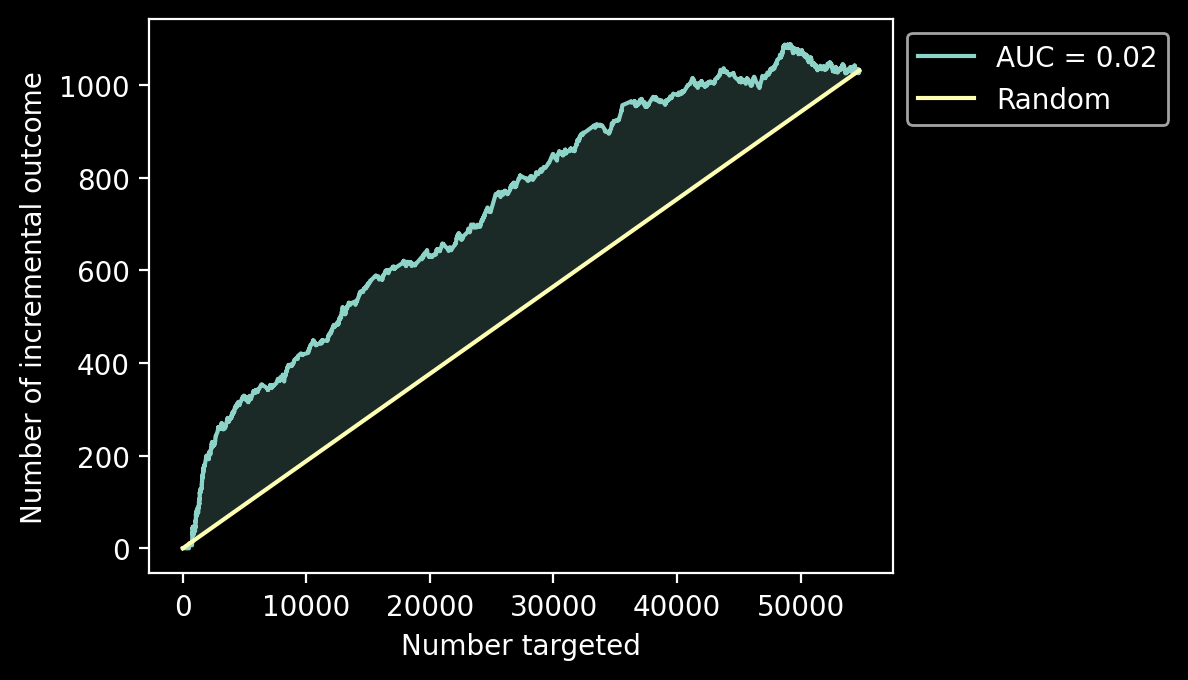

In [66]:
from sklift.viz import plot_qini_curve

# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_test, uplift_ct, treat_test, perfect=False);